# Compare regression results from author population groups
Compare the regression results that we find when we run separate context regressions on different author populations (based on [this metadata](./classify_authors_by_metadata.ipynb)):

- ORG vs. non-ORG
- local vs. non-local

This will help us determine whether the overall context use change is due to a population change.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load regression results

In [2]:
# convert tex to table
def tex_to_table(file_name):
    data = pd.read_csv(file_name, sep='&', header=None, skiprows=4, skipfooter=2, engine='python')
    data.columns = ['var', 'coeff', 'err', 'p']
    data = data.assign(**{
        'p' : data.loc[:, 'p'].apply(lambda x: x.replace(r' \\', ''))
    })
    # fix floats
    float_cols = ['coeff', 'err', 'p']
    for f in float_cols:
        data = data.assign(**{
            f : data.loc[:, f].astype(float)
        })
    return data
## organization
organization_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_organization=1.tsv', sep='\t', index_col=0)
non_organization_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_organization=0.tsv', sep='\t', index_col=0)
# organization_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_organization=1.tsv', sep='\t', index_col=0)
# non_organization_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_organization=0.tsv', sep='\t', index_col=0)
## local
local_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_is_local=1.tsv', sep='\t', index_col=0)
non_local_reg_coeffs = pd.read_csv('../../output/anchor_regularized_logit_output_anchor~C(data_name_fixed)+C(username)+C(NE_fixed)+during_peak+post_peak+has_URL+image_video_URL+txt_len_norm+since_start+NE_count_prior_split_is_local=0.tsv', sep='\t', index_col=0)

## Load raw data
Let's plot how many posts were generated by different author groups.

In [3]:
import dateutil
from datetime import datetime, timedelta
def round_to_day(x):
    x_day = datetime(day=x.day, month=x.month, year=x.year)
    return x_day
def fix_timezone(x, date_fmt='%Y-%m-%d %H:%M:%S', timezone_str='+0000'):
    # add timezone offset for "naive" dates
    if(x.utcoffset() is None):
        x = datetime.strptime('%s%s'%(x.strftime(date_fmt), timezone_str), '%s%%z'%(date_fmt))
    return x
def assign_peak_date(data, count_var='NE_count', date_var='date_day'):
    max_count = data.loc[:, count_var].max()
    peak_date = data[data.loc[:, count_var] == max_count].loc[:, date_var].iloc[0]
    return peak_date
def load_consistent_data():
    # load full data
    full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # load anchor data
    anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # fix bad usernames
    anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})

    date_var = 'date'
    full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    anchor_data = anchor_data.assign(**{date_var : anchor_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    ## add time var

    round_date_var = '%s_day'%(date_var)
    full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
    anchor_data = anchor_data.assign(**{round_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
        ## add NE peak dates
    NE_var = 'NE_fixed'
    round_date_var = 'date_day'
    data_name_var = 'data_name_fixed'
    NE_counts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
    id_var = 'id'
    doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
    NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
    NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})
    k_consistent = 5
    NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
    NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= k_consistent].reset_index().loc[:, [data_name_var, NE_var]]
    NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')

    count_var = 'NE_count'
    NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
    anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
    peak_date_buffer = timedelta(days=1)
    peak_date_var = 'peak_date'
    round_date_var = 'date_day'
    anchor_data_consistent = anchor_data_consistent.assign(**{
        'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
        'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
        'during_peak' : ((anchor_data_consistent.loc[:, round_date_var] > anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer) & (anchor_data_consistent.loc[:, round_date_var] < anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer)).astype(int)
    })
    return anchor_data_consistent

In [4]:
context_data = load_consistent_data()

In [5]:
## add metadata
meta_data_file = '../../data/mined_tweets/tweet_user_data/user_meta_data_clean.tsv'
meta_data = pd.read_csv(meta_data_file, sep='\t', index_col=False)

In [6]:
author_var = 'username'
data_name_var = 'data_name_fixed'
# clean author names for merging
meta_data = meta_data.assign(**{author_var : meta_data.loc[:, author_var].apply(lambda x: x.lower())})
context_data = context_data.assign(**{author_var : context_data.loc[:, author_var].apply(lambda x: x.lower())})
# merge
meta_data_vars = ['organization', 'is_local']
context_data_meta = pd.merge(context_data, meta_data.loc[:, [author_var, data_name_var] + meta_data_vars], on=[author_var, data_name_var], how='inner')

In [7]:
display(context_data_meta.loc[:, 'organization'].value_counts())
display(context_data_meta.loc[:, 'is_local'].value_counts())

0    96217
1    14614
Name: organization, dtype: int64

 0    58613
 1    37597
-1    14621
Name: is_local, dtype: int64

In [8]:
## compute post counts in meta x time periods
org_post_counts = context_data_meta.groupby('organization').apply(lambda x: x.loc[:, ['pre_peak', 'during_peak', 'post_peak']].sum(axis=0))
loc_post_counts = context_data_meta[context_data_meta.loc[:, 'is_local'] != -1].groupby('is_local').apply(lambda x: x.loc[:, ['pre_peak', 'during_peak', 'post_peak']].sum(axis=0))
org_post_counts = org_post_counts / org_post_counts.sum(axis=0)
loc_post_counts = loc_post_counts / loc_post_counts.sum(axis=0)
display(org_post_counts)
display(loc_post_counts)

,pre_peak,during_peak,post_peak
organization,,,
0,0.890736,0.885925,0.838912
1,0.109264,0.114075,0.161088


,pre_peak,during_peak,post_peak
is_local,,,
0,0.575442,0.637997,0.612026
1,0.424558,0.362003,0.387974


## Plot results

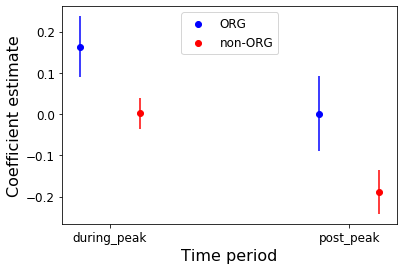

In [11]:
## organization
time_coeffs = ['during_peak', 'post_peak']
org_time_means = organization_reg_coeffs.loc[time_coeffs, 'mean']
non_org_time_means = non_organization_reg_coeffs.loc[time_coeffs, 'mean']
org_time_errs = organization_reg_coeffs.loc[time_coeffs, 'SE']
non_org_time_errs = non_organization_reg_coeffs.loc[time_coeffs, 'SE']
X = np.arange(len(time_coeffs))
X_buffer = 0.125
bar_width = 0.125
plt.figure(figsize=(6,4))
ax1 = plt.subplot(111)
# ax2 = ax1.twinx()
ax1.tick_params(axis='both', which='major', labelsize=12)

## context use coefficient estimates
# means
ax1.scatter(X - X_buffer, org_time_means, color='b', label='ORG')
ax1.scatter(X + X_buffer, non_org_time_means, color='r', label='non-ORG')
# errs
ax1.errorbar(X - X_buffer, org_time_means, yerr=org_time_errs, color='b', label=None, linestyle='none')
ax1.errorbar(X + X_buffer, non_org_time_means, yerr=non_org_time_errs, color='r', label=None, linestyle='none')
ax1.set_xticks(X)
ax1.set_xticklabels(time_coeffs)
ax1.legend(loc='upper center', fontsize=12)
ax1.set_xlabel('Time period', fontsize=16)
ax1.set_ylabel('Coefficient estimate', fontsize=16)

## post counts
## leave out because bars are confusion
# ax2.bar(X - X_buffer, org_post_counts.loc[1, ['during_peak', 'post_peak']].values, width=bar_width, color='b', alpha=0.25)
# ax2.bar(X + X_buffer, org_post_counts.loc[0, ['during_peak', 'post_peak']].values, width=bar_width, color='r', alpha=0.25)
# ax2.set_ylabel('Post volume', rotation=270, fontsize=16, labelpad=20)

plt.show()

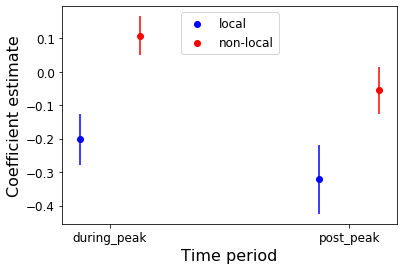

In [12]:
## locals
time_coeffs = ['during_peak', 'post_peak']
local_time_means = local_reg_coeffs.loc[time_coeffs, 'mean']
non_local_time_means = non_local_reg_coeffs.loc[time_coeffs, 'mean']
local_time_errs = local_reg_coeffs.loc[time_coeffs, 'SE']
non_local_time_errs = non_local_reg_coeffs.loc[time_coeffs, 'SE']
X = np.arange(len(time_coeffs))
X_buffer = 0.125
bar_width = 0.125
plt.figure(figsize=(6,4))
ax1 = plt.subplot(111)
# ax2 = ax1.twinx()
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=12)

## context use coefficient estimates
# means
ax1.scatter(X - X_buffer, local_time_means, color='b', label='local')
ax1.scatter(X + X_buffer, non_local_time_means, color='r', label='non-local')
# errs
ax1.errorbar(X - X_buffer, local_time_means, yerr=local_time_errs, color='b', label=None, linestyle='none')
ax1.errorbar(X + X_buffer, non_local_time_means, yerr=non_local_time_errs, color='r', label=None, linestyle='none')
ax1.set_xticks(X)
ax1.set_xticklabels(time_coeffs)
ax1.legend(loc='upper center', fontsize=12)
ax1.set_xlabel('Time period', fontsize=16)
ax1.set_ylabel('Coefficient estimate', fontsize=16)

## post counts
## leave out because bars are confusion
# ax2.bar(X - X_buffer, loc_post_counts.loc[1, ['during_peak', 'post_peak']].values, width=bar_width, color='b', alpha=0.25)
# ax2.bar(X + X_buffer, loc_post_counts.loc[0, ['during_peak', 'post_peak']].values, width=bar_width, color='r', alpha=0.25)
# ax2.set_ylabel('Post volume', rotation=270, fontsize=16, labelpad=20)

plt.show()